# Aineiston esikäsittely

Perustuu kirjan [Applied Predictive Modeling](http://appliedpredictivemodeling.com/) kolmanteen kappaleeseen Data Pre-processing.

Alkuperäiset esimerkit on toteutettu R-kielellä.

Materiaalina käytetään [solujen automatisoidun analysoinnin onnistumiseen vaikuttavien tekijöiden merkitystä selvittäneen tutkimuksen aineistoa](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-340).

Ladataan käytettävät paketit:

In [123]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import boxcox, kurtosis, skew

Määritetään suorituksen aikana käytettävät vakiot

In [111]:
BC_FIX = 0.1 # Sarakkeen pienimmän arvon itseisarvoon tehtävä lisäys

Luetaan käytettävä aineisto:

In [112]:
dataUrl = "https://raw.githubusercontent.com/RaimoHaikari/data-analytiikka/main/applied-predictive-modelling/data/segmentationOriginal.csv"
segmentationOriginal = pd.read_csv(dataUrl)
segmentationOriginal.head() 

,Cell,Case,Class,AngleCh1,AngleStatusCh1,AreaCh1,AreaStatusCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,...,VarIntenCh1,VarIntenCh3,VarIntenCh4,VarIntenStatusCh1,VarIntenStatusCh3,VarIntenStatusCh4,WidthCh1,WidthStatusCh1,XCentroid,YCentroid
0,207827637,Test,PS,143.247705,1,185,0,15.711864,3.954802,9.548023,...,12.474676,7.609035,2.714100,0,2,2,10.642974,2,42,14
1,207932307,Train,PS,133.752037,0,819,1,31.923274,205.878517,69.916880,...,18.809225,56.715352,118.388139,0,0,0,32.161261,1,215,347
2,207932463,Train,WS,106.646387,0,431,0,28.038835,115.315534,63.941748,...,17.295643,37.671053,49.470524,0,0,0,21.185525,0,371,252
3,207932470,Train,PS,69.150325,0,298,0,19.456140,101.294737,28.217544,...,13.818968,30.005643,24.749537,0,0,2,13.392830,0,487,295
4,207932455,Test,PS,2.887837,2,285,0,24.275735,111.415441,20.474265,...,15.407972,20.504288,45.450457,0,0,0,13.198561,0,283,159


Sarakkeista:

- *Cell* toimii yksilöivänä tietona
- *Class* on luokkamuuttuja, jonka avulla nähdään mitkä solut onnistuttiin luokittelemaan hyvin
- *Case* kertoo, kuuluiko näyte tutkimuksessa opetus- vai testijoukkoon

Kirjan esimerkki keskittyy opetusmateriaaliin, joten kopioidaan se omaan muuttujaansa.

Käytetään copy() -toimintoa, jotta yhteys alkuperäiseen aineistoon katkeaa.

In [113]:
ehto = segmentationOriginal['Case'] == 'Train'
segData = segmentationOriginal[ehto].copy(deep=True)

Mapataan Cell, Class ja Case omiin muuttujiinsa ja poistetaan ne kehikosta.

In [114]:
cellID = segData['Cell'].values
cellClass = segData['Class'].values
cellCase = segData['Case'].values

segData.drop(['Cell', 'Class', 'Case'], axis=1, inplace = True)

Aineisto sisältää useita sarakkeita, joiden nimessä on maininta: status. Näitä sarakkeita on käytetty ennusteiden manuaaliseen luokitteluun.

Poistetaan nämä sarakkeet:

In [115]:
# segData.columns.values
matching = [s for s in segData.columns.values if "Status" in s]
segData.drop(matching, axis=1, inplace = True)
segData.shape

(1009, 58)

## Muunnokset

Osalla muuttujista arvoissa esiintyy huomattavaa vinoutumista. 

Käydään sarakkeet läpi ja lasketaan kunkin muuttujan vinous. Arvoja voidaan käyttää esim. valittaessa muuttujia visuaalisen tarkastelun kohteeksi.

Huom. joillain muuttujilla antaa hieman kirjan esimerkistä poikkeavia arvoja, voi johtua esim. siitä, että ajan [skew-funktion](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) oletusarvoilla.


- peukalosääntönä pidetään 0.75 raja-arvon ylittymistä, mikäli suurempi, vinoutta voidaan pitää merkittävänä


In [116]:

skewValues = segData.apply(skew, axis=0)
skewValues.nlargest()

KurtIntenCh1              12.878789
KurtIntenCh4               6.928801
EqEllipseProlateVolCh1     6.079871
EqSphereVolCh1             5.748045
KurtIntenCh3               5.513805
dtype: float64

### Box-Cox muunnos

Vinon aineiston oikaisuun käytettyjä menetelmiä ovat mm. logaritmin- , neliöjuuren - ja käänteisluvun laskeminen.

Muunnoksen jälkeen jakauma ei edelleenkään ole normaali, mutta 'käyttäytyy paremmin'.

Tilastotieteilijät Box ja Cox ovat esitelleen menetelmän, jonka avulla tarvittavan oikaisu voidaan matemaattisesti selvittää. Menetelmä perustuu havainnoista laskettavan tunnusluvun käyttöön.

Menetelmän käyttö edellyttää, että muuttujan arvot ovat nollaa suurempia. Yksi vaihtoehto negatiivisiä arvoja sisältävien sarakkeiden käsittelyyn on [vakioarvon lisääminen](https://stats.stackexchange.com/questions/399435/which-constant-to-add-when-applying-box-cox-transformation-to-negative-values). 

Selvitetään siltääkö aineisto *ei positiivisia* arvoja sisältäviä sarakkeita. Mikäli tällaisia sarakkeita löytyy, lisätään kuhunkin muuttujaan vakioarvo, joka on:

- pienimmän arvon itseisarvo plus 0.1 (BC_FIX)

Talletaan samalla muistiin käsitellyt sarakkeet ja suoritetut korjaukset.

In [119]:
def hasNegativeValues(x):
    return sum(x <= 0)

bcPreFixes = {}

nOfNegativeValues = segData.apply(lambda x: hasNegativeValues(x))

for (col,val) in nOfNegativeValues[nOfNegativeValues > 0].items():
    fix = abs(segData[col].min()) + BC_FIX

    bcPreFixes[col] = fix
    segData[col] += fix

Käytetään BoxCox muunnokseen scipy.stats paketista löytyvää [boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)-funktiota.

Funktio palauttaa tuple:n, jossa:

- ensimmäinen arvo sisältää muuttenut havainnot
- toinen arvo sisältää alkuperäisistä arvoista lasketun lambda-arvon.

Apply-funktio lapioi arvot kehikkoon (data.frame).

In [135]:
dfBoxCoxTF = segData.apply(lambda x: boxcox(x))

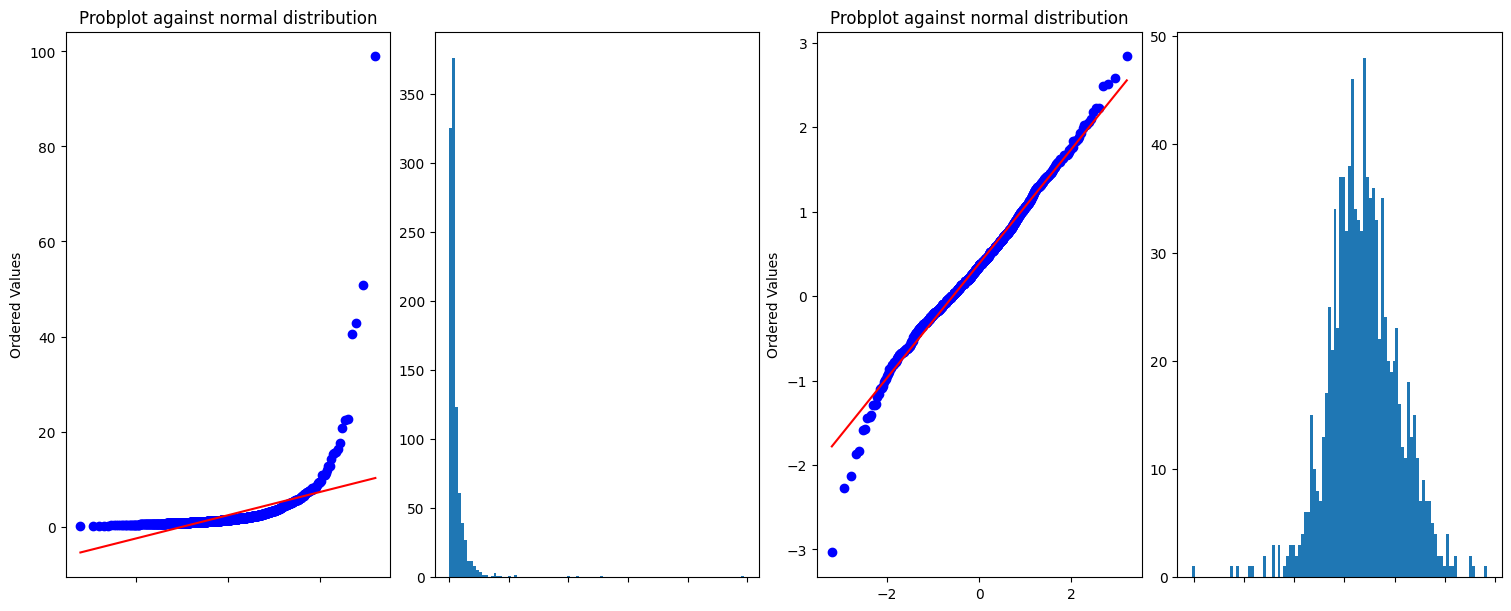

In [158]:
from scipy import stats

kwargs = dict(histtype='stepfilled', alpha=1.0, bins=100, density = False)


fig = plt.figure(constrained_layout=True, figsize=(15,6))
spec = plt.GridSpec(ncols=4, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, 0], xticklabels=[])
ax2 = fig.add_subplot(spec[0, 1], xticklabels=[])
ax3 = fig.add_subplot(spec[0 ,2])
ax4 = fig.add_subplot(spec[0, 3], xticklabels=[])

x = segData['KurtIntenCh1'].values

prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2.hist(segData['KurtIntenCh1'].values, **kwargs);

x = dfBoxCoxTF.iloc[0,:]['KurtIntenCh1']

prob = stats.probplot(x, dist=stats.norm, plot=ax3)
ax3.set_xlabel('')
ax3.set_title('Probplot against normal distribution')

ax4.hist(dfBoxCoxTF.iloc[0,:]['KurtIntenCh1'], **kwargs);


In [ ]:


fig = plt.figure()
ax1 = fig.add_subplot(211)

#x = stats.loggamma.rvs(5, size=500) + 5
x = segData['KurtIntenCh1'].values

prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

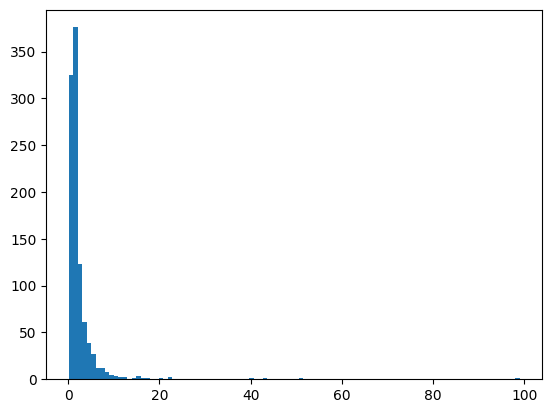

In [150]:
kwargs = dict(histtype='stepfilled', alpha=1.0, bins=100, density = False)
plt.hist(segData['KurtIntenCh1'].values, **kwargs);

In [ ]:
# dfBoxCoxTF.iloc[0,:]['KurtIntenCh1']

fig = plt.figure()
ax1 = fig.add_subplot(211)

#x = stats.loggamma.rvs(5, size=500) + 5
x = dfBoxCoxTF.iloc[0,:]['KurtIntenCh1']

prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

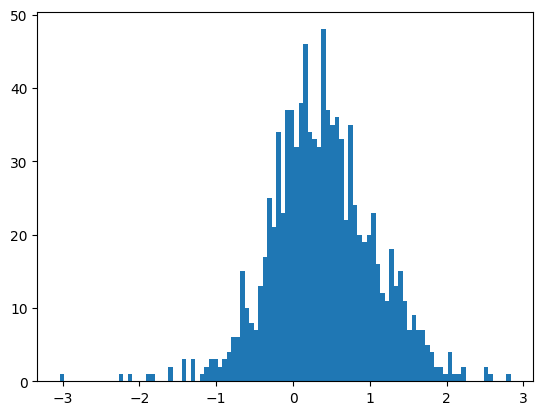

In [151]:
plt.hist(dfBoxCoxTF.iloc[0,:]['KurtIntenCh1'], **kwargs);